In [13]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split

In [14]:
import pytorch_lightning as pl
import pandas as pd
from PIL import Image
from sklearn import metrics

In [15]:
import cv2
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Define Model

In [16]:
class Classifier(pl.LightningModule):
    def __init__(self, pos_weight : torch.Tensor = torch.Tensor(1)):
        """
        Args:
            pos_weight (tensor): weighting of positive class loss to negative class loss
        """
        super(Classifier, self).__init__()
        self.model = models.resnet18(pretrained=False)
        # change 1st conv layer from 3 channel to 1 channel
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        #change to single output
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)
        self.pos_weight = pos_weight
        self.BCELoss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def configure_optimizers(self):
        optim_momentum = 0.2
        optim_weight_decay = 1e-5
        optim_lr = 0.01
        optimizer = torch.optim.SGD(self.model.parameters(), lr=optim_lr,
                                    momentum=optim_momentum,
                                    weight_decay=optim_weight_decay
                                   )
        return optimizer
    
    def BCE_loss(self, logits, labels):
        return self.BCELoss(logits, labels.float())
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)   # we already defined forward and loss in the lightning module. We'll show the full code next
        logits = torch.flatten(logits)
        loss = self.BCE_loss(logits, y)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        logits = torch.flatten(logits)
        loss = self.BCE_loss(logits, y)
        self.log('val_loss', loss)
        
    def predict(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x

In [17]:
class CXRDataset(Dataset):
    def __init__(self, excel_path : str = "./", img_dir : str = "./",
                 img_brt_std : float = 0.10448302):
        """
        Args:
            excel_path (string): Path to excel file with ids and labels.
            img_dir (string): Directory with all the png images.
            img_brt_std (float): Standard deviation of brightness of training dataset.
        """
        self.dataset = self.prepare_dataset(excel_path)
        self.img_dir = img_dir
        self.img_brt_std = img_brt_std
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            #transforms.ColorJitter(brightness=img_brt_std),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        
    def prepare_dataset(self, excel_path):
        df = pd.read_excel(excel_path)
        df = df.sort_values(by='Abnormal', ascending=False)
        df = df.drop_duplicates(subset="image_id", keep="first")
        df = df.sample(frac=1).reset_index(drop=True)
        return df
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.dataset['image_id'].iloc[idx] + '.png')
        image = Image.open(img_path)
        image = self.transform(image)
        label = self.dataset['Nodule/Mass'].iloc[idx]
        uuid = self.dataset['image_id'].iloc[idx]
        return image, label

In [18]:
class DataModule(pl.LightningDataModule):
    def __init__(self, img_dir: str = "./", train_file: str = "./",
                 val_file:str="./", batch_size: int = 24):
        """
        Args:
            img_dir (string): Directory with all the png images.
            train_file (string): path to train image excel
            val_file (string): path to validation image excel
            batch_size (int): batch size for training
        """
        super().__init__()
        self.img_dir = img_dir
        self.train_file = train_file
        self.val_file = val_file
        self.batch_size = batch_size
        self.num_workers = num_workers
    
    def prepare_data(self):
        self.train_data = CXRDataset(self.train_file, self.img_dir)
        self.val_data = CXRDataset(self.val_file, self.img_dir)
        
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size)
        

## Train Model

In [19]:
dataset = DataModule('imgs/', './train.xlsx', './test.xlsx')
dataset.prepare_data()

In [20]:
num_pos = dataset.train_data.dataset['Nodule/Mass'].sum()
num_neg = len(dataset.train_data.dataset['Nodule/Mass']) - num_pos
pos_weight = torch.Tensor([num_neg / num_pos])

In [21]:
model = Classifier(pos_weight=pos_weight)

In [24]:
trainer = pl.Trainer(resume_from_checkpoint='lightning_logs/version_15/checkpoints/epoch=19-step=8339.ckpt',
                     checkpoint_callback=True, max_epochs=20, logger=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [25]:
trainer.fit(model, dataset.train_dataloader(), dataset.val_dataloader())
trainer.save_checkpoint("models/node_improved_model_3-sgd-nobri.ckpt")

Restoring states from the checkpoint file at lightning_logs/version_15/checkpoints/epoch=19-step=8339.ckpt
Restored all states from the checkpoint file at lightning_logs/version_15/checkpoints/epoch=19-step=8339.ckpt

  | Name    | Type              | Params
----------------------------------------------
0 | model   | ResNet            | 11.2 M
1 | BCELoss | BCEWithLogitsLoss | 0     
2 | sigmoid | Sigmoid           | 0     
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


EPOCH FIN NO BRIGHTNESS

In [61]:
sgd_nobr_model = Classifier()

In [84]:
sgd_nobr_model = sgd_nobr_model.load_from_checkpoint(checkpoint_path="lightning_logs/version_15/checkpoints/epoch=19-step=8339.ckpt")

In [85]:
labels, pred_list = validate(model, dataset.val_dataloader())

In [110]:
results = analysis(labels, pred_list, threshold=0.05)

In [111]:
results['auc']

0.8157416089564717

In [112]:
results['precision']

array([0.96782497, 0.20852018])

In [113]:
results['recall']

array([0.80990845, 0.65034965])

In [114]:
results['fscore']

array([0.88185283, 0.31578947])

In [115]:
results['precision']

array([0.96782497, 0.20852018])

In [116]:
results['recall']

array([0.80990845, 0.65034965])

In [117]:
results['fscore']

array([0.88185283, 0.31578947])

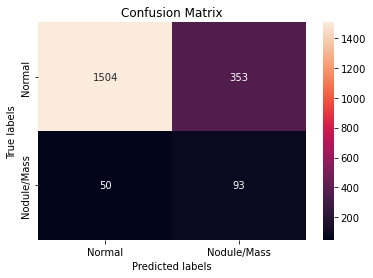

In [118]:
plot_confusion_matrix(results['confusion_matrix'])

In [35]:
results['support']

array([1857,  143])

In [44]:
np.save('evaluation/sgd-nob_fpr.npy', results['fpr'])
np.save('evaluation/sgd-nob_tpr.npy', results['tpr'])

In [50]:
base_fpr = np.load('evaluation/baseline_fpr.npy')
base_tpr = np.load('evaluation/baseline_tpr.npy')
adam_fpr = np.load('evaluation/adam_fpr.npy')
adam_tpr = np.load('evaluation/adam_tpr.npy')
sgd_nob_fpr = np.load('evaluation/sgd-nob_fpr.npy')
sgd_nob_tpr = np.load('evaluation/sgd-nob_tpr.npy')

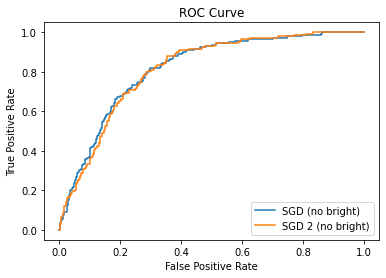

In [83]:
#plt.plot(base_fpr, base_tpr, label='Baseline')
plt.plot(sgd_nob_fpr, sgd_nob_tpr, label='SGD (no bright)')
plt.plot(results['fpr'], results['tpr'], label='SGD 2 (no bright)')
#plt.plot(adam_fpr, adam_tpr, label='Adam')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.legend()

In [132]:
roc_curve = metrics.RocCurveDisplay(fpr=base_fpr, tpr=base_tpr)

In [136]:
print(' AUC:', results['auc'], '\n Precision: ', results['precision'],
      '\n Recall: ', results['recall'], '\n F-Score: ', results['fscore'])

 AUC: 0.8174889192659791 
 Precision:  [0.97902622 0.17293233] 
 Recall:  [0.70382337 0.8041958 ] 
 F-Score:  [0.81892231 0.28465347]


In [ ]:
roc_curve = metrics.RocCurveDisplay(fpr=base_fpr, tpr=base_tpr)

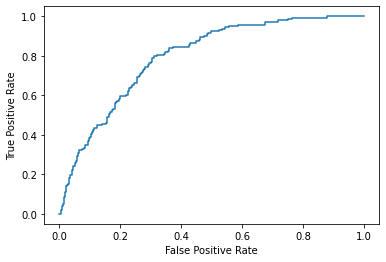

In [134]:
roc_curve.plot()

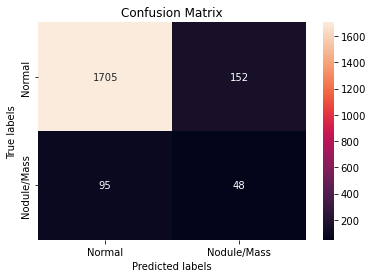

In [38]:
plot_confusion_matrix(results['confusion_matrix'])

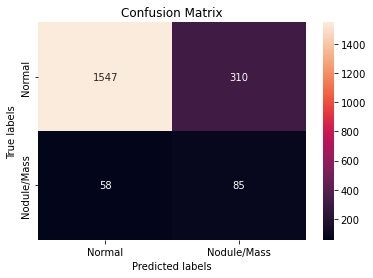

In [39]:
results = analysis(labels, pred_list, threshold=0.09)
plot_confusion_matrix(results['confusion_matrix'])

BRIGHTNESS SGD

In [37]:
trainer = pl.Trainer(resume_from_checkpoint='models/node_improved_model_2-sgd-fe14.ckpt',
                     checkpoint_callback=True, max_epochs=20, logger=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [38]:
trainer.fit(model, dataset.train_dataloader(), dataset.val_dataloader())
trainer.save_checkpoint("models/node_improved_model_2-sgd-fin.ckpt")

Restoring states from the checkpoint file at models/node_improved_model_2-sgd-fe14.ckpt
Restored all states from the checkpoint file at models/node_improved_model_2-sgd-fe14.ckpt

  | Name    | Type              | Params
----------------------------------------------
0 | model   | ResNet            | 11.2 M
1 | BCELoss | BCEWithLogitsLoss | 0     
2 | sigmoid | Sigmoid           | 0     
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 14:  83%|████████▎ | 417/501 [27:54<05:36,  4.01s/it, loss=0.604, v_num=12]
Validating: 0it [00:00, ?it/s]
Epoch 15:  83%|████████▎ | 417/501 [27:58<05:37,  4.02s/it, loss=0.482, v_num=12] 
Validating: 0it [00:00, ?it/s]
Epoch 16:  83%|████████▎ | 418/501 [27:57<05:32,  4.00s/it, loss=0.468, v_num=12] 
Validating: 0it [00:00, ?it/s]
Epoch 17:  83%|████████▎ | 418/501 [27:52<05:31,  3.99s/it, loss=0.464, v_num=12] 
Validating: 0it [00:00, ?it/s]
Epoch 18:  83%|████████▎ | 418/501 [27:54<05:31,  4.00s/it, loss=0.466, v_num=12] 
Validating: 0it [00:00, ?it/s]
Epoch 19:  83%|████████▎ | 418/501 [27:53<05:31,  3.99s/it, loss=0.431, v_num=12] 
Validating: 0it [00:00, ?it/s]
Epoch 19: 100%|██████████| 501/501 [29:53<00:00,  3.57s/it, loss=0.431, v_num=12]


## Evaluate Model

In [27]:
def validate(model, val_loader):
    labels = []
    pred_list = []
    for x, y in val_loader:
        #x = x.to(device)
        preds = model.predict(x)
        labels += list(y.detach().cpu().numpy())
        pred_list += list(preds.detach().cpu().numpy())
    return labels, pred_list

In [28]:
def analysis(labels, pred_list, threshold : float = 0.5):
    results = {}
    results['fpr'], results['tpr'], results['thresholds'] = metrics.roc_curve(labels, pred_list)
    results['auc'] = metrics.auc(results['fpr'], results['tpr'])
    
    pred_class_list = []
    for logit in pred_list:
        if logit >= threshold:
            pred_class = 1
        else:
            pred_class = 0
        pred_class_list.append(pred_class)
    
    prfs = metrics.precision_recall_fscore_support(labels, pred_class_list)
    results['precision'], results['recall'], results['fscore'], results['support'] = prfs
    
    results['confusion_matrix'] = metrics.confusion_matrix(labels, pred_class_list)
    
    return results

def plot_confusion_matrix(confusion_matrix):
    
    ax = plt.subplot()
    sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Normal', 'Nodule/Mass']); ax.yaxis.set_ticklabels(['Normal', 'Nodule/Mass']);


EPOCH FIN

In [46]:
sgd_br_model = Classifier()

In [139]:
sgd_br_model = sgd_br_model.load_from_checkpoint(checkpoint_path="models/node_improved_model_2-sgd-fin.ckpt")

In [140]:
labels, pred_list = validate(sgd_br_model, dataset.val_dataloader())

In [141]:
results = analysis(labels, pred_list, threshold=0.09)

In [142]:
results['auc']

0.8083456661808843

In [122]:
results['auc']

0.8174889192659791

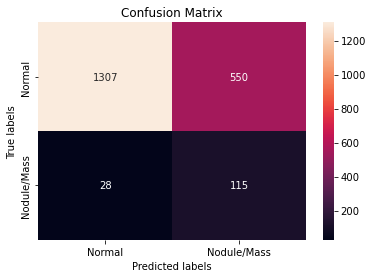

In [123]:
plot_confusion_matrix(results['confusion_matrix'])

In [131]:
results['auc']

0.8174889192659791

In [128]:
results['precision']

array([0.97902622, 0.17293233])

In [129]:
results['recall']

array([0.70382337, 0.8041958 ])

In [130]:
results['fscore']

array([0.81892231, 0.28465347])

In [45]:
results['support']

array([1857,  143])

In [55]:
base_fpr = np.load('evaluation/baseline_fpr.npy')
base_tpr = np.load('evaluation/baseline_tpr.npy')

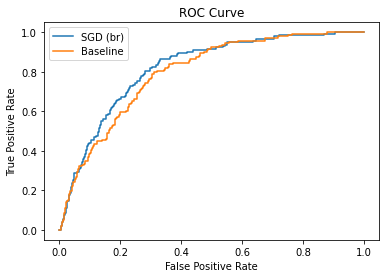

In [127]:
plt.plot(results['fpr'], results['tpr'], label='SGD (br)')
#plt.plot(sgd_nob_fpr, sgd_nob_tpr, label='SGD (no br)')
#plt.plot(adam_fpr, adam_tpr, label='Adam')
plt.plot(base_fpr, base_tpr, label='Baseline')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.legend()

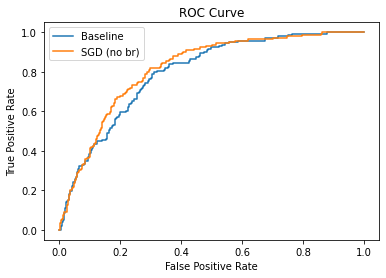

In [53]:
plt.plot(base_fpr, base_tpr, label='Baseline')
plt.plot(sgd_nob_fpr, sgd_nob_tpr, label='SGD (no br)')

#plt.plot(adam_fpr, adam_tpr, label='Adam')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.legend()

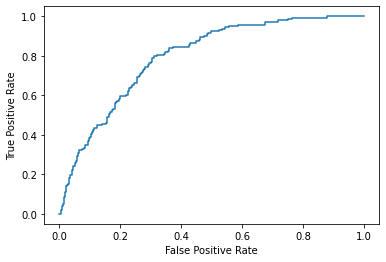

In [56]:
roc_curve = metrics.RocCurveDisplay(fpr=base_fpr, tpr=base_tpr)

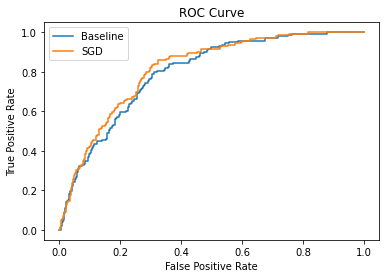

In [67]:
plt.plot(base_fpr, base_tpr, label='Baseline')
plt.plot(results['fpr'], results['tpr'], label='SGD')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.legend()

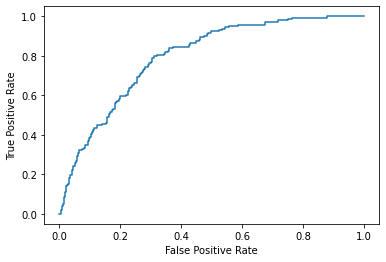

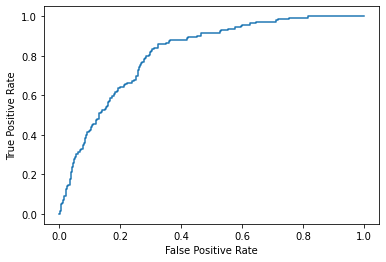

In [57]:
roc_curve = metrics.RocCurveDisplay(fpr=base_fpr, tpr=base_tpr)
roc_curve.plot()
roc_curve = metrics.RocCurveDisplay(fpr=results['fpr'], tpr=results['tpr'])
roc_curve.plot()
plt.show()

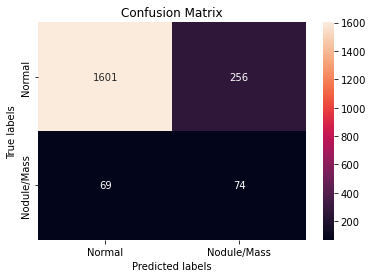

In [47]:
plot_confusion_matrix(results['confusion_matrix'])

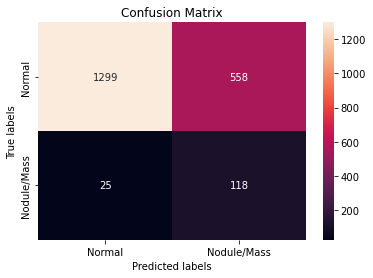

In [72]:
results = analysis(labels, pred_list, threshold=0.09)
plot_confusion_matrix(results['confusion_matrix'])

EPOCH 14

In [28]:
labels, pred_list = validate(model, dataset.val_dataloader())

In [29]:
results = analysis(labels, pred_list)

In [30]:
results['auc']

0.8102473724444645

In [31]:
results['precision']

array([0.95840979, 0.20547945])

In [32]:
results['recall']

array([0.84383414, 0.52447552])

In [33]:
results['fscore']

array([0.89747995, 0.29527559])

In [34]:
results['support']

array([1857,  143])

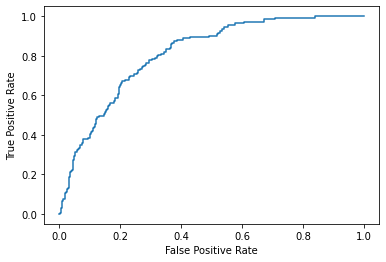

In [35]:
roc_curve = metrics.RocCurveDisplay(fpr=results['fpr'], tpr=results['tpr'])
roc_curve.plot()
plt.show()

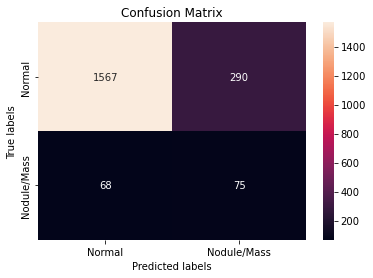

In [36]:
plot_confusion_matrix(results['confusion_matrix'])

EPOCH 10

In [17]:
labels, pred_list = validate(model, dataset.val_dataloader())

In [18]:
results = analysis(labels, pred_list)

In [19]:
results['auc']

0.7985885950344754

In [20]:
results['precision']

array([0.97928749, 0.14880202])

In [21]:
results['recall']

array([0.6365105 , 0.82517483])

In [22]:
results['fscore']

array([0.77154047, 0.25213675])

In [23]:
results['support']

array([1857,  143])

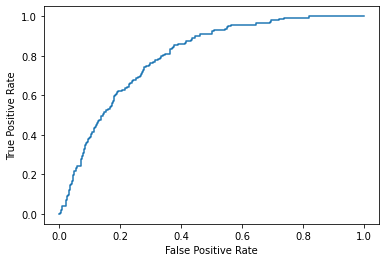

In [24]:
roc_curve = metrics.RocCurveDisplay(fpr=results['fpr'], tpr=results['tpr'])
roc_curve.plot()
plt.show()

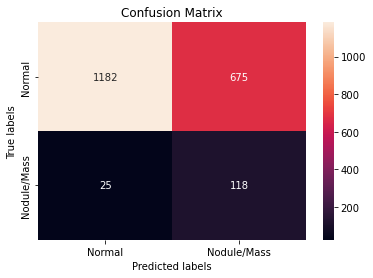

In [25]:
plot_confusion_matrix(results['confusion_matrix'])

# Optimise

In [12]:
dataset.train_data.dataset.groupby(['Nodule/Mass', 'Abnormal']).count()

Unnamed: 0  image_id
Nodule/Mass Abnormal                      
0           0               7045      7045
            1               2418      2418
1           1                537       537

## Experiments

### Brightness

In [61]:
def get_brightness_means(img_dataset: DataModule):
    
    brightness_means = []
    for sample in img_dataset:
        img = sample[0]
        brightness_means.append(img.mean())
        
    return brightness_means

In [62]:
means = get_brightness_means(dataset.train_data)

<AxesSubplot:ylabel='Count'>

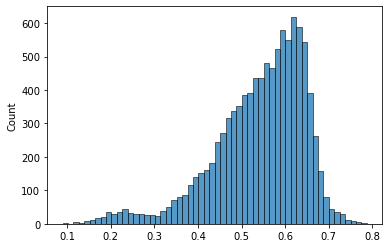

In [63]:
sns.histplot(np.array(means))

In [202]:
np.std(means)

0.10448302

In [66]:
np.mean(means)

0.5407106

In [247]:
img_num = 0

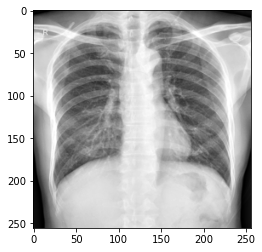

In [248]:
img_path = os.path.join('imgs/', dataset.train_data.dataset['image_id'].iloc[img_num] + '.png')
image = Image.open(img_path)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

In [138]:
type(results['confusion_matrix'])

numpy.ndarray

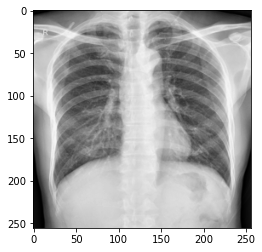

In [265]:
plt.imshow(dataset.train_data[img_num][0].squeeze(), cmap='gray', vmin=-1, vmax=1)

In [181]:
img_num += 1

## Evaluation

- ROC Curve.
- Thresholding Plot (histogram of prediction probability) compare Nodule/Mass label vs Normal label
- Threshold choice w/ consideration of business problem